# 자전거 대여 예측모델-autogluon

이 노트북에서는 역사적 이용 패턴 + 날씨 데이터를 결합하여

 워싱턴 D.C. Capital Bikeshare 프로그램의 시간별 자전거 수요를 예측합니다.

# 목차
1. 데이터 로드 및 탐색
2. 컬럼별 데이터 분석 및 시각화
3. 전처리 및 특성 엔지니어링
4. 모델링 및 최초 성능확인
5. 모델링 (AutoGluon) 과 앙상블
6. 내부평가 및 Autogluon submission.csv 파일 생성

## 1. 데이터 로드 및 탐색

1.1 환경 설정 및 데이터 확인

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularPredictor

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

pd.read_csv("train.csv")

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


  시즌1은 봄이고, 시즌4는 겨울.
  홀리데이가 전부 0인 거로 보아 휴일이 없었나보다. 적어도 겉보기엔. -> 실제12/19일이 아니었음.

  워킹데이가 0이다가 12/19일엔 1씩 된 걸 보면 새해에만 예외로 쉬게 해주나 보군.

  weather는 왜 전부 1일까? -> 모름 -> 공교롭게도 날씨가 좋았다고 함 -> 다르게 얘기하면 
  중간에 1이 아닌 숫자도 있었을 것 -> print(df['weather'].value_counts())로 확인해보자.

  확인 결과 -> 1이 아닌 숫자도 있었음 근데 왜 4인 건 하나 뿐이지?
  temp 실제 기온이 연말이 좀 추웠네. 중간 기온들도 좀 볼까?
   -> 평균이 20이고, 최저0.8, 최대 41이네
  근데 std가 뭐지? -> 여기서 std가 어떤 의미인지 확인이 필요함 -> ?????
  근데 컬럼이 23개 랬었는데 왜 트레인 컬럼이 12개 밖에 안되는가.
  
  atemp가 뭔지 확인 -> atemp는 체감온도 -> temp를 사용할 때, 
   atemp를 같이 보면 좋을 것 같음.
  풍속이 12/19일과, 1/1의 등록자수에 영향을 주는지 확인해볼 필요는 있어보임.

  

In [2]:
df = pd.read_csv(r'C:\Users\user\Desktop\bike-sharing-demand-BSD\train.csv')
df['count'].describe()
# 평균이 181인데 최대가 977임. 대여수량 차이가 너무 심함.

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [3]:
df.shape
#10900개의 행과 12개의 열임(12개의 컬럼)

(10886, 12)

In [4]:
df.info()
# 실수3개와 정수 8개와 텍스트(문자열)1개가 있음 -> 텍스트는 날짜타입으로 바꿔줘야 함.
# 결측치가 0개임.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## 2. 컬럼별 데이터 분석 및 시각화

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None


In [6]:
df['year'] = df['datetime'].dt.year  
df['hour'] = df['datetime'].dt.hour   
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,dayofweek,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,0,5,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2,5,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,3,5,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,4,5,1,1


In [7]:
eda_df = train.copy()
print(eda_df.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


## 2.1 컬럼별 갯수 재확인

In [8]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'hour', 'dayofweek', 'month', 'day'],
      dtype='object')

In [9]:
df.info()
# 결측치가 0개인 거 확인함, 데이터타입 오브젝트 사라진 거 확인.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  hour        10886 non-null  int32         
 14  dayofweek   10886 non-null  int32         
 15  month       10886 non-null  int32         
 16  day         10886 non-

# 2.2 시간대별 평균 대여량 분석

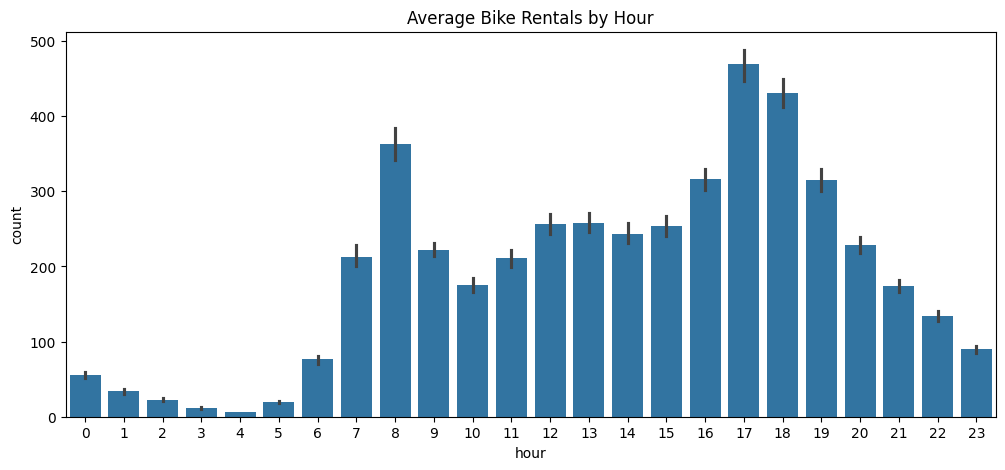

In [10]:
# 1. 시간대별(hour) 평균 대여량(count) 시각화

plt.figure(figsize=(12, 5))  #figsize=(12, 5): 도화지의 가로와 세로 길이를 정하는 옵션
sns.barplot(x='hour', y='count', data=df)
plt.title('Average Bike Rentals by Hour')
plt.show()
# 오후 5시, 아침8시가 유독 뾰족함. -> 새벽 3시와의 차이가 심한 거로 보아
# 새벽5시나 새벽6시까지만 자전거를 재배치하면 될 것으로 보이는 것을 알 수 있음.
# 오후 19시와 오전 8시의 검은색 줄의 길이가 유독 차이가 남. 분명 길이가 비슷함에도 차이가 나는 걸로 보아
# 뭔가 이상한 걸 알 수 있음.

# 2.3 기상 및 기온에 따른 대여량 분석 

2.3.1 날씨

In [11]:
print(df['weather'].value_counts())

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64


2.3.2 기온

In [12]:
# 기온 데이터의 최솟값, 25%, 50%, 75%, 최댓값 확인
print(df['temp'].describe())

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64


2.3.3 체감온도

In [13]:
print(df['atemp'].describe())
# temp와 atemp의 평균값과 표준편차는 별 차이가 없음. 전체적으로 같이 움직이는 듯 함.

count    10886.000000
mean        23.655084
std          8.474601
min          0.760000
25%         16.665000
50%         24.240000
75%         31.060000
max         45.455000
Name: atemp, dtype: float64


2.3.4 온도와 대여량의 관계 시각화

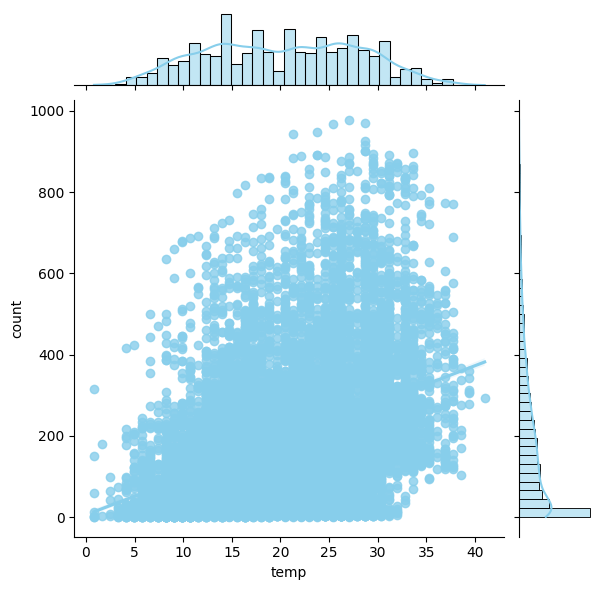

In [14]:
# 온도와 대여량의 관계 (산점도 + 회귀선)
sns.jointplot(data=eda_df, x='temp', y='count', kind='reg', color='skyblue')
plt.show()


In [15]:
sns.regplot

<function seaborn.regression.regplot(data=None, *, x=None, y=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, label=None, color=None, marker='o', scatter_kws=None, line_kws=None, ax=None)>

# 2.4 풍속과 등록자수 및 상관관계 분석

In [16]:
# 'datetime'에서 월과 일을 추출하여 특정 날짜만 필터링
target_days = df[((df['month'] == 12) & (df['day'] == 19)) | 
                 ((df['month'] == 1) & (df['day'] == 1))]

# 날짜, 풍속, 등록자수, 전체대여량만 선택해서 출력
print(target_days[['datetime', 'windspeed', 'registered', 'count']])

                 datetime  windspeed  registered  count
0     2011-01-01 00:00:00     0.0000          13     16
1     2011-01-01 01:00:00     0.0000          32     40
2     2011-01-01 02:00:00     0.0000          27     32
3     2011-01-01 03:00:00     0.0000          10     13
4     2011-01-01 04:00:00     0.0000           1      1
...                   ...        ...         ...    ...
10881 2012-12-19 19:00:00    26.0027         329    336
10882 2012-12-19 20:00:00    15.0013         231    241
10883 2012-12-19 21:00:00    15.0013         164    168
10884 2012-12-19 22:00:00     6.0032         117    129
10885 2012-12-19 23:00:00     8.9981          84     88

[96 rows x 4 columns]


In [17]:
# 전체 데이터에서 풍속과 등록자수의 상관관계 계산
correlation = df['windspeed'].corr(df['registered'])
print(f"풍속과 등록자수 사이의 상관계수: {correlation:.2f}")
# 0.09인 거로 보아 풍속과 등록자수는 관계가 없는 듯 함.

풍속과 등록자수 사이의 상관계수: 0.09


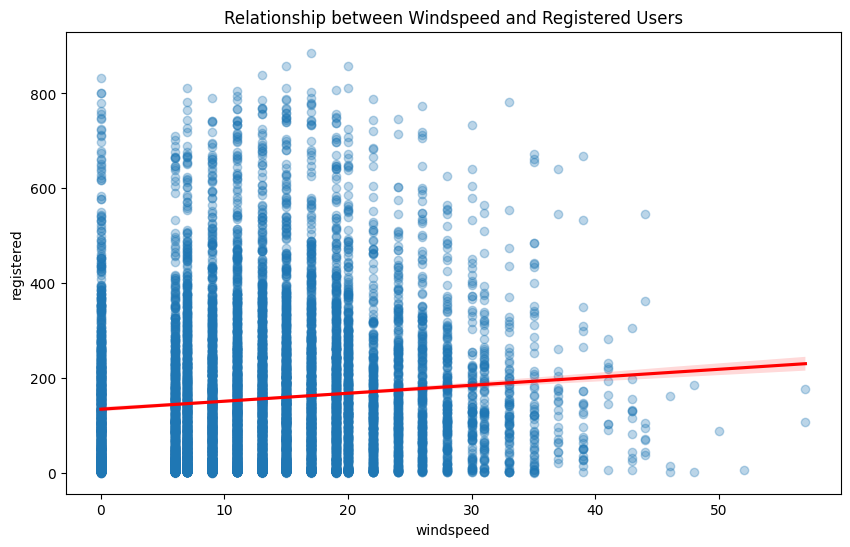

In [18]:
plt.figure(figsize=(10, 6))
# 산점도에 추세선(regline)을 추가해서 경향성 확인 (빨간선이 추세선임) 
sns.regplot(x='windspeed', y='registered', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relationship between Windspeed and Registered Users')
plt.show()
# 풍속이 0~30일 때, 등록자들이 많고, 풍속이 30을 넘어가면 등록자들이 점차 줄어드는 것으로 보아 관계가 있어보임.
# 그런데 위에서 상관관계만 봤을 때는 관계가 없다고 판단되었었음. 뭔가 이상하니 확인 필요함.
# 또는 제외할 필요가 있을지도 모름.

# 2.5 평일/주말 시간대별 대여량 시각화 및 분석

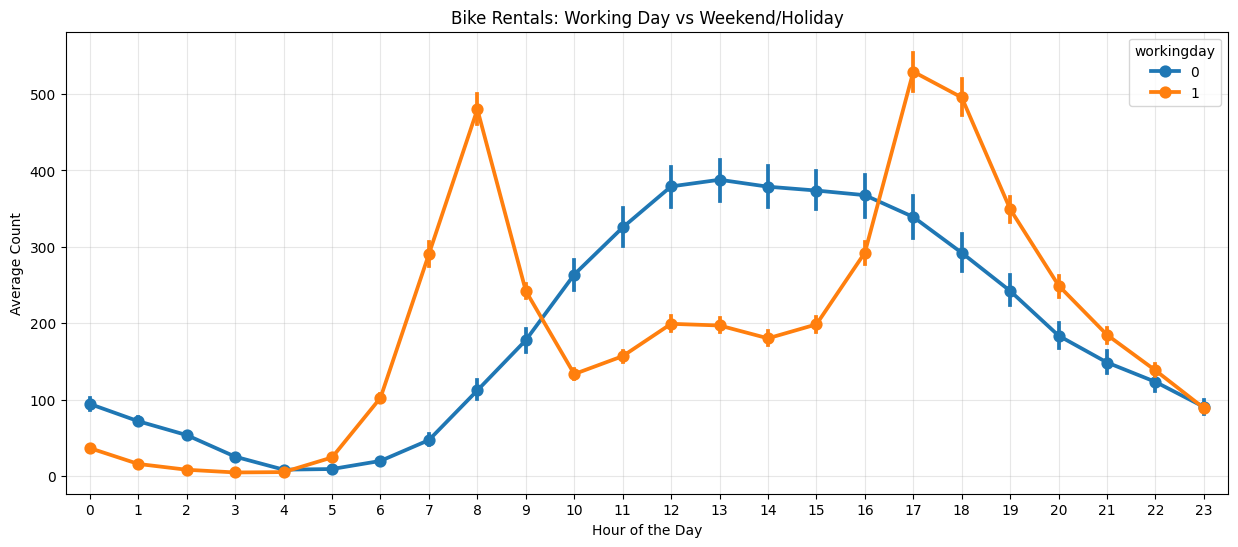

In [19]:
# 1. 도화지 준비 (가로로 길게)
plt.figure(figsize=(15, 6))

# 2. 시간대별 대여량을 평일/주말(hue='workingday')로 나누어 그리기
sns.pointplot(data=df, x='hour', y='count', hue='workingday')

plt.title('Bike Rentals: Working Day vs Weekend/Holiday')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Count')
plt.grid(True, alpha=0.3)
plt.show()

새벽4시에 사용량이 최저점임. 파란색선은 쉬는 날, 주황색선은 일하는 날.
대체로 이용하는 사람들이 적어지는 시간대에는 고정 이용객들만 이용하는 것을 알 수 있음.

# 3. 전처리와 특성 엔지니어링

3.1 결측치 재확인

In [20]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
hour          0
dayofweek     0
month         0
day           0
dtype: int64

3.2 전처리를 실행하기에 앞서 할지말지에 대한 지금까지의 분석 재확인

df['count'].describe()
평균이 181인데 최대가 977임. 대여수량 차이가 너무 심함.

시간대별(hour) 평균 대여량(count) 시각화에서
오후 5시, 아침8시가 유독 뾰족함. -> 새벽 3시와의 차이가 심한 거로 보아 이상함.
오후 19시와 오전 8시의 검은색 줄의 길이가 유독 차이가 남. 분명 길이가 비슷함에도 차이가 나는 걸로 보아
뭔가 이상한 걸 알 수 있음.

풍속과 등록자들 사이의 이상한 의문점. 풍속과 등록자들의 상관관계는 관계없다고 얘기하나,
풍속 30 이상일 때, 등록자들이 점차 줄어드는 걸 보면 관계가 있음. 그러니 이상한 데이터임.

전체적으로 이상치가 많은 데이터들이라 
모델이 이 '너무 튀는 값'에 휘둘리지 않도록 
나중에 Log Transformation(로그 변환)을 할지 결정하는 근거가 됨.



# feature engineering
# 전체적으로 새벽4시는 규칙적이고 변동성이 적어서 모델이 안정적으로 점수를 확보할 수 있는 시간대임.



In [21]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,dayofweek,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,0,5,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2,5,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,3,5,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,4,5,1,1


3.3 풍속의 전처리 여부 검토

    풍속과 등록자들 사이의 이상한 의문점. 풍속과 등록자들의 상관관계는 관계없다고 얘기하나,
    풍속 30 이상일 때, 등록자들이 점차 줄어드는 걸 보면 관계가 있음. 그러니 이상한 데이터임.
    지워 버리는 게 맞는 것 같긴 하나, 풍속을 오토글론이 어떤 방식으로 학습할지 몰라 남겨두고 
    결과를 확인하는 편이 좋다고 판단. 그러나 로그 함수로 리스크 관리하는 게 
    좋은 것 같으니 추후 모델링 과정에서 다시 조정할 예정임. 

# 4. 모델링 및 최초 성능확인

In [22]:
# =====================================================
# 1️⃣ 데이터 로딩
# =====================================================
train = pd.read_csv("train.csv")  # 1~19일 학습용
test = pd.read_csv("test.csv")    # 20~말일 제출용

# =====================================================
# 2️⃣ 피처 엔지니어링
# =====================================================
for df in [train, test]:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df['month'] = df['datetime'].dt.month

# 학습용: 타겟 제거
y_train = np.log1p(train['count']) 
train = train.drop(columns=['count', 'casual', 'registered'])

# =====================================================
# 3️⃣ 범주형 변수 One-Hot Encoding (최신 scikit-learn)
# =====================================================
categorical_cols = ['season', 'weather', 'weekday', 'month', 'hour']
encoder = OneHotEncoder(sparse_output=False, drop='first')

encoder.fit(train[categorical_cols])
X_train_cat = encoder.transform(train[categorical_cols])
X_test_cat = encoder.transform(test[categorical_cols])

# 숫자형 컬럼 결합
num_cols = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed']
X_train = np.hstack([X_train_cat, train[num_cols].values])
X_test = np.hstack([X_test_cat, test[num_cols].values])

# 스케일링 (선택)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

# =====================================================
# 4️⃣ 모델 학습
# =====================================================
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_part, y_train_part)

val_preds = model.predict(X_val)
print(f"자체 검증 RMSLE: {np.sqrt(mean_squared_error(y_val, val_preds))}")
# =====================================================
# 5️⃣ 제출용 예측
# =====================================================
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, None)

submission = pd.DataFrame({
    'datetime': test['datetime'],
    'count': y_pred
})

submission = pd.DataFrame({
    'datetime': test['datetime'],
    'count': y_pred
})
submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성 완료!")

자체 검증 RMSLE: 0.4762205530357259
submission.csv 파일 생성 완료!


# 5. 모델링(autogloun) 과 앙상블

5.1 AutoGluon 학습 및 검증과 평가

In [ ]:
ag_train = pd.read_csv("train.csv")
ag_train['datetime'] = pd.to_datetime(ag_train['datetime'])
ag_train['hour'] = ag_train['datetime'].dt.hour
ag_train['weekday'] = ag_train['datetime'].dt.weekday
ag_train['month'] = ag_train['datetime'].dt.month
ag_train = ag_train.drop(columns=['casual', 'registered'])

predictor = TabularPredictor(
    label='count', 
    problem_type='regression',
    eval_metric='root_mean_squared_error'
).fit(
    train_data=ag_train,
    time_limit=600, 
    presets='best_quality'  # 앙상블
)

leaderboard = predictor.leaderboard(extra_info=True)
print(leaderboard)

No path specified. Models will be saved in: "AutogluonModels\ag-20260203_065931"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          22
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       20.39 GB / 31.74 GB (64.2%)
Disk Space Avail:   294.78 GB / 454.67 GB (64.8%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.


(_ray_fit pid=19812) [1000]	valid_set's rmse: 35.4337
(_ray_fit pid=23196) [2000]	valid_set's rmse: 36.0724 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=11160) [3000]	valid_set's rmse: 35.9552 [repeated 12x across cluster]
(_ray_fit pid=19508) [4000]	valid_set's rmse: 35.8171 [repeated 11x across cluster]
(_ray_fit pid=19508) [5000]	valid_set's rmse: 35.5895 [repeated 8x across cluster]
(_ray_fit pid=19508) [6000]	valid_set's rmse: 35.4525 [repeated 6x across cluster]
(_ray_fit pid=25672) [8000]	valid_set's rmse: 36.7198 [repeated 8x across cluster]


(_dystack pid=18132) 	-35.2731	 = Validation score   (-root_mean_squared_error)
(_dystack pid=18132) 	45.76s	 = Training   runtime
(_dystack pid=18132) 	5.9s	 = Validation runtime
(_dystack pid=18132) Fitting model: LightGBM_BAG_L1 ... Training model for up to 41.15s of the 89.05s of remaining time.
(_dystack pid=18132) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=2, gpus=0, memory=0.12%)


(_ray_fit pid=6412) [1000]	valid_set's rmse: 35.9357 [repeated 8x across cluster]
(_ray_fit pid=26700) [3000]	valid_set's rmse: 36.0536 [repeated 13x across cluster]


(_dystack pid=18132) 	-34.406	 = Validation score   (-root_mean_squared_error)
(_dystack pid=18132) 	15.28s	 = Training   runtime
(_dystack pid=18132) 	1.27s	 = Validation runtime
(_dystack pid=18132) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 21.01s of the 68.90s of remaining time.
(_dystack pid=18132) 	Fitting 1 model on all data (use_child_oof=True) | Fitting with cpus=22, gpus=0, mem=0.0/17.9 GB
(_dystack pid=18132) 	-38.9787	 = Validation score   (-root_mean_squared_error)
(_dystack pid=18132) 	2.28s	 = Training   runtime
(_dystack pid=18132) 	0.65s	 = Validation runtime
(_dystack pid=18132) Fitting model: CatBoost_BAG_L1 ... Training model for up to 17.79s of the 65.68s of remaining time.
(_dystack pid=18132) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=2, gpus=0, memory=2.19%)
(_ray_fit pid=3544) 	Ran out of time, early stopping on iteration 2057.
(_dystack pid=18132) 	-34.5489	 = Validation s

5.2 최종 보정

In [ ]:
# predictor는 학습 시 사용한 변수명입니다
predictions = predictor.predict(test)

# 혹시 모를 음수 값 방지 (자전거 대여량은 0보다 작을 수 없으니까요)
predictions = np.clip(predictions, 0, None)

print(predictions.head())

0    13.838020
1     4.308285
2     3.546901
3     3.482786
4     3.223553
Name: count, dtype: float32


5.3 autogloun 변수 중요도 분석 및 시각화

Computing feature importance via permutation shuffling for 12 features using 5000 rows with 5 shuffle sets...
	634.16s	= Expected runtime (126.83s per shuffle set)
	383.26s	= Actual runtime (Completed 5 of 5 shuffle sets)


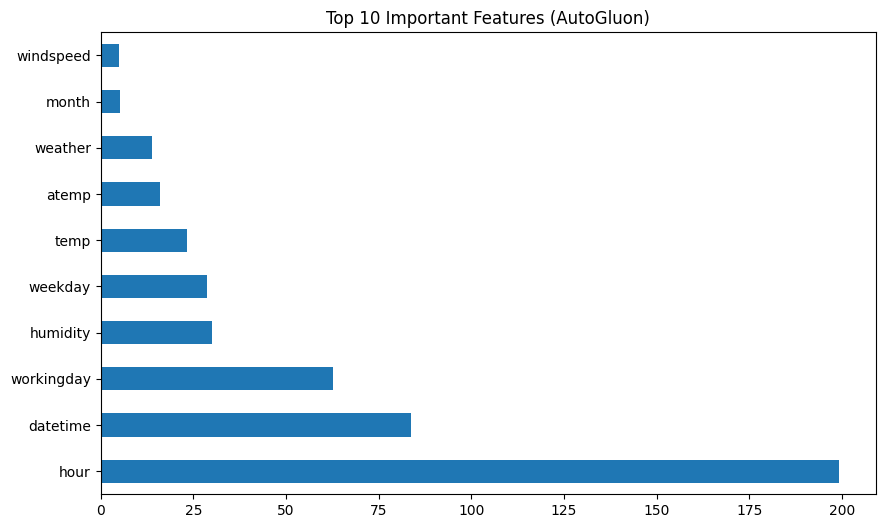

In [ ]:
importance = predictor.feature_importance(data=ag_train)

# 상위 10개 시각화
plt.figure(figsize=(10, 6))
importance['importance'].head(10).plot(kind='barh')
plt.title('Top 10 Important Features (AutoGluon)')
plt.show()

5.4 autogloun 최종 모델 저장

In [ ]:
# 1. 제출 양식 불러오기 (보통 sampleSubmission.csv가 제공됩니다)
submission = pd.read_csv('sampleSubmission.csv')

# 2. 예측값 채워넣기 (예측값 후처리 및 저장)
submission['count'] = predictions

# 3. 파일로 저장
submission.to_csv('my_autogluon_submission.csv', index=False)

print("제출 파일 생성 완료! 'my_autogluon_submission.csv'를 확인하세요.")

제출 파일 생성 완료! 'my_autogluon_submission.csv'를 확인하세요.


## 완료

Autogluon을 사용하여 향후 특정 시간대의 **대여 수량(count)**을 예측하는 모델을 완성하였습니다.

### 요약
- **데이터분석**: 컬럼별 대여량 분석
- **전처리와 특성엔지니어링**: 결측치 재확인 및 컬럼별 특징에 따른 전처리 여부
- **모델링**: 베이스라인 모델 생성 및 autogloun 모델 생성
- **앙상블**: presets='best_quality' 옵션을 활용한 autogluon의 최종모델 도출
- **평가**: RMSLE 평가지표를 사용하여 모델 성능 평가
- **제출**: submission_autogluon.csv 파일 생성



